# Hedging Option with DDPG

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yfinance as yf


from collections import namedtuple, deque
import random
from torch.distributions import Normal

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Use device: ", DEVICE)

## Prepare Data


### Download Data

In [3]:
# Start date and End date
start_date = '2012-01-01'
end_date = '2024-01-01'

America_tickers1 = ['AAPL']
America_data1 = yf.download(America_tickers1, start=start_date, end=end_date)['Adj Close']


America_array1 = np.array(America_data1.dropna())


# Parameters
window_size = 30 + 1
num_windows = len(America_array1) - window_size + 1

# Initialize the new array
transformed_data = np.zeros(( num_windows, window_size))

# Shift the data to make it start with 100
for i in range(num_windows):
    transformed_data[i] = America_array1[i:i + window_size] #- America_array1[i] + 100


print("\nShape of transformed_data: ",transformed_data.shape)  # Should print (30, 2739)



[*********************100%%**********************]  1 of 1 completed


Shape of transformed_data:  (2988, 31)


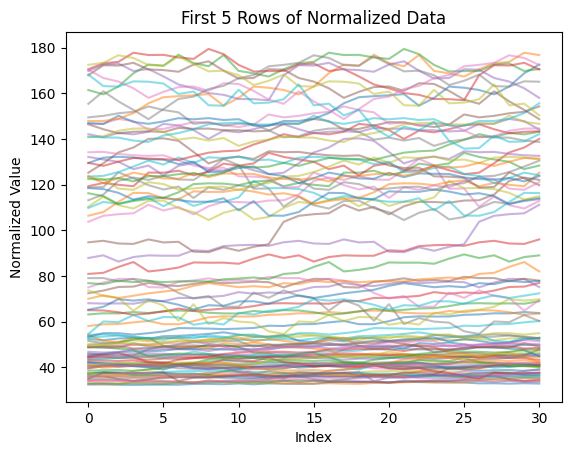

In [4]:

# Plot the first 100 Path
for i in range(100):
  plt.plot(transformed_data[i*13+1300],alpha = 0.5)

plt.title('First 5 Rows of Normalized Data')
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.show()


### Split Data

In [5]:
# Split the data
# The first 2500 for training, the rest for testing

Stock_prices = torch.from_numpy(America_array1).float().T

Training_data = torch.from_numpy(transformed_data[100:2700]).float().T
Testing_data = torch.from_numpy(transformed_data[2700:]).float().T
print("Shape of Training data: ",Training_data.shape)
print("Shape of Testing  data: ",Testing_data.shape)

Shape of Training data:  torch.Size([31, 2600])
Shape of Testing  data:  torch.Size([31, 288])


<ipython-input-5-d160162bdad7>:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  Stock_prices = torch.from_numpy(America_array1).float().T


In [6]:
print(Training_data.shape[1])

2600


### Calculate the std for the testing data

In [7]:
std_Windows = 100
std_num_windows = 2988 - std_Windows

print(std_num_windows)
# Initialize the new array
std_data = np.zeros(( std_num_windows))


# Shift the data to make it start with 100
for i in range(std_num_windows):
    data_prev = America_array1[i:i+100]
    data_next = America_array1[i+1:i+101]
    temp = np.log(data_next / data_prev[0])
    std_data[i] = np.std(temp)

    # data_return = np.log((data_prev - 100)/100)

    # std_data[i] = np.std(data_prev)


training_std_data = torch.from_numpy(std_data[:2600]).float()
training_std_data = training_std_data.reshape(-1,1)

testing_std_data = torch.from_numpy(std_data[2600:]).float()
testing_std_data = testing_std_data.reshape(-1,1)


2888


In [8]:
print(training_std_data.shape)
print(testing_std_data.shape)

torch.Size([2600, 1])
torch.Size([288, 1])


In [9]:
print("Shape of stock price: ", Stock_prices.shape)

print("Shape of Training data: ",Training_data.shape)
print("Shape of Testing  data: ",Testing_data.shape)

print("Shape of Training std: ",training_std_data.shape)
print("Shape of Testing  std: ",testing_std_data.shape)

Shape of stock price:  torch.Size([3018])
Shape of Training data:  torch.Size([31, 2600])
Shape of Testing  data:  torch.Size([31, 288])
Shape of Training std:  torch.Size([2600, 1])
Shape of Testing  std:  torch.Size([288, 1])


In [10]:
print(Stock_prices[100:131] - Training_data[:,0])
print(Stock_prices[100+3:130])
print(Stock_prices[130])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([17.4444, 16.9389, 17.0386, 16.9945, 17.2551, 17.2629, 17.5226, 17.2463,
        17.3970, 17.2762, 17.2572, 17.3357, 17.6875, 17.7367, 17.6863, 17.4426,
        17.5764, 17.2343, 17.2723, 17.3469, 17.1823, 17.6337, 17.8910, 18.0990,
        18.4170, 18.2944, 18.5362])
tensor(18.3647)


State := (history stock prices$_{1 x N}$, history volatilities$_{1 x 1}$, time to maturity$_{1 x 1}$, hedge position$_{1 x 1}$).


Action := The position we have (0~1).

Reward := The profit and loss due to the action.

done := When time equal to $T$, sell all the stock postion and pay the customers.


In [ ]:
import numpy as np



class MarketEnv:
    def __init__(self, eval, PATHS, volatilities, option_maturity, transaction_cost):
        self.eval = eval
        self.current_path = 0

        self.PATHS = PATHS
        self.num_paths = PATHS.shape[1]
        self.num_steps = PATHS.shape[0]
        self.pnl = 0

        self.PATH_N = -1


        self.volatilities = volatilities
        self.option_maturity = option_maturity
        self.transaction_cost = transaction_cost

        self.current_step = 0
        self.done = False
        self.reset()

    def reset(self):
        if self.eval:
            self.PATH_N =  self.PATH_N + 1
        else:
            # self.PATH_N = (self.PATH_N + 1)% self.num_paths
            self.PATH_N = np.random.randint(0, self.num_paths-1)

        # self.PATH_N = 1077



        # print("PATH NUM: ", self.PATH_N)
        self.current_step = 0
        self.done = False
        self.pnl = 0


        self.current_path = self.PATHS[:, self.PATH_N]
        self.current_volatility = self.volatilities[self.PATH_N]

        self.position = 0  # Agent's position in the underlying asset
        self.cash = 0  # Agent's cash balance

        # if self.PATHS[0, self.PATH_N] % 5 == 0:
        #     self.strike_price = self.PATHS[0, self.PATH_N]
        # else:
        #     self.strike_price = self.PATHS[0, self.PATH_N] + (5 - self.PATHS[0, self.PATH_N] % 5)


        self.strike_price = self.PATHS[0, self.PATH_N]

        # plt.plot(self.current_path, color = 'red')
        # plt.xlabel('Time')
        # plt.ylabel('Stock Price')
        # plt.title('Stock Price Over Time')
        # plt.show()



        return self._get_state()

    def _get_state(self):

        # print("stock shape : ", Stock_prices.shape)

        # if self.eval:
        #     hist_prices =  Stock_prices[100 + self.PATH_N + self.current_step - 30: 100 + self.PATH_N + self.current_step] /  Stock_prices[100 + self.PATH_N + self.current_step - 30]

        # else:
        #     hist_prices =  Stock_prices[100 + self.PATH_N + self.current_step - 30: 100 + self.PATH_N + self.current_step] /  Stock_prices[100 + self.PATH_N + self.current_step - 30]  # 1 x 30
        # print("hist stock shape : ", hist_prices)
        # print("stock price : ", self.current_path)

        hist_prices = (self.current_path[self.current_step] / self.current_path[0]).log()
        hist_prices = hist_prices.reshape(-1)

        vol = self.volatilities[self.PATH_N]

        time_to_maturity = (self.option_maturity - self.current_step) / 365

        position = self.position


        state = torch.cat((hist_prices, vol, torch.tensor([time_to_maturity]), torch.tensor([position])))
        # print("hist shape",hist_prices.shape)
        # print("State shape : ",state.shape)

        return state

    def step(self, action):
        if self.done:
            raise Exception("Environment has finished. Please reset the environment.")

        stock_price = self.current_path[self.current_step]
        next_stock_price = self.current_path[self.current_step + 1]

        transaction_cost = self.transaction_cost * abs(action - self.position) * stock_price
        self.pnl += action * (next_stock_price - stock_price) - transaction_cost

        self.position = action




        self.current_step += 1

        if self.current_step >= self.option_maturity:
            self.done = True
            # print("================   END   ================")
            # print(next_stock_price)
            # print(self.strike_price)

            option_payoff = max(int(0), next_stock_price - self.strike_price)


            # print("option payoff : ", option_payoff)
            # print("cash :", self.cash)
            # print("stock value :", self.position * next_stock_price)
            # print("position :", self.position)
            # print("=========================================")
            # plt.plot(self.current_path, color = 'red')
            # plt.xlabel('Time')
            # plt.ylabel('Stock Price')
            # plt.title('Stock Price Over Time')
            # plt.show()


            reward = self.pnl - option_payoff
            self.position = 0
        else:
            reward = action * (next_stock_price - stock_price) - transaction_cost

        next_state = self._get_state()
        return next_state, reward, self.done, {"cash": self.cash, "position": self.position}

# Example usage
PATHS = np.linspace(100, 130, 31)  # Example stock prices
volatilities = np.linspace(20, 50, 31)  # Example volatilities

env = MarketEnv( True, Training_data, training_std_data, option_maturity=30,  transaction_cost=0.01)

plt.plot(env.current_path, color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Over Time')
plt.show()

for i in range(10):
  state = env.reset()


  # Run an episode
  positions = []
  done = False
  hist_reward = []
  hist_cash = []
  while not done:
      action = np.random.rand()  # Example random action, replace with a policy for better results
      next_state, reward, done, info = env.step(action)


      positions.append(env.position)
      hist_reward.append(reward)

  # Plot the positions over time
  plt.plot(positions)
  plt.xlabel('Time step')
  plt.ylabel('Position')
  plt.title('Position changes over time')
  plt.show()

  # Plot the reward over time
  plt.plot(hist_reward)
  plt.plot(hist_cash, color = 'black')
  plt.xlabel('Time step')
  plt.ylabel('Reward')
  plt.title('Reward changes over time')
  plt.show()



## Black-Sholes model Delta Hedging

In [ ]:
# Parameters
window_size = 30 + 1
num_windows = len(America_array1) - window_size + 1

# Initialize the new array
transformed_data = np.zeros(( num_windows, window_size))

# Shift the data to make it start with 100
for i in range(num_windows):
    transformed_data[i] = America_array1[i:i + window_size] - America_array1[i] + 100

Training_data = torch.from_numpy(transformed_data[100:2700]).float().T
Testing_data = torch.from_numpy(transformed_data[2700:]).float().T


In [ ]:
std_Windows = 100
std_num_windows = 2988 - std_Windows

print(std_num_windows)
# Initialize the new array
std_data = np.zeros(( std_num_windows))


# Shift the data to make it start with 100
for i in range(std_num_windows):
    data_prev = America_array1[i:i+100] - America_array1[i] + 100
    data_next = America_array1[i+1:i+101] - America_array1[i] + 100
    temp = np.log(data_next / 100)
    std_data[i] = np.std(temp)

    # data_return = np.log((data_prev - 100)/100)

    # std_data[i] = np.std(data_prev)


training_std_data = torch.from_numpy(std_data[:2600]).float()
training_std_data = training_std_data.reshape(-1,1)

testing_std_data = torch.from_numpy(std_data[2600:]).float()
testing_std_data = testing_std_data.reshape(-1,1)


In [ ]:
## Deep Hedging

std_Windows = 100
std_num_windows = 2988 - std_Windows

print(std_num_windows)
# Initialize the new array
deep_std_data = np.zeros(( std_num_windows))


# Shift the data to make it start with 100
for i in range(std_num_windows):
    data_prev = America_array1[i:i+100] - America_array1[i] + 100

    std_data[i] = np.std(data_prev)


deep_training_std_data = torch.from_numpy(deep_std_data[:2600]).float()
deep_training_std_data = deep_training_std_data.reshape(-1,1)

deep_testing_std_data = torch.from_numpy(deep_std_data[2600:]).float()
deep_testing_std_data = deep_testing_std_data.reshape(-1,1)

In [ ]:

T = 30/252
dt = 1/252
s0 = 100


def european_option_payoff(prices: torch.Tensor, strike=100):
    return fn.relu(prices[-1, :] - strike)

def european_option_delta(log_moneyness, time_expiry, volatility) :
    s, t, v =  log_moneyness, time_expiry, volatility
    normal = Normal(torch.tensor(0.0), torch.tensor(1.0))
    return normal.cdf((s + (v ** 2 / 2) * t) / (v * torch.sqrt(t)))
def BS_compute_modelhedge_pnl( T, dt, sigma, paths, payoff, cost) :

    Paths = paths

    hedge = torch.zeros_like(Paths[:1]).reshape(-1)
    pnl = 0
    hedge_weight = torch.zeros_like(Paths)

    x_log_moneyness = torch.full_like(Paths[0, :], s0/100).log()

    x_sigma = sigma
    print(x_sigma.shape)

    for n in range(Paths.shape[0] - 1):
        x_time_expiry = torch.full_like(x_log_moneyness, T - n * dt)
        prev_hedge = hedge

        # print(torch.log(Paths[n,:]/100).shape)
        # print(x_time_expiry.shape)
        # print(x_sigma[:].shape)
        # print("--------")

        hedge = european_option_delta(torch.log(Paths[n,:]/100), x_time_expiry[:], x_sigma[:])

        hedge_weight[n] = hedge
        pnl += (hedge) * (Paths[n + 1] - Paths[n])

        pnl -= cost * torch.abs(hedge - prev_hedge) * Paths[n]

    pnl -= payoff(Paths)
    return pnl , hedge_weight


AAPL_with_Americacost, hedge_weight_AAPL_with_Americacost = BS_compute_modelhedge_pnl(T=T, dt=dt, sigma=testing_std_data.reshape(-1), paths=Testing_data, payoff=european_option_payoff, cost=0.01)
print(AAPL_with_Americacost.shape)


In [ ]:
plt.hist(AAPL_with_Americacost.cpu().detach().numpy(), bins = 20, density = True, alpha = 0.6,
         label = f'Delta Hedging\nmean = {AAPL_with_Americacost.mean():2.2f} std = {AAPL_with_Americacost.std():2.2f}')
plt.title(f"PnL of Delta hedging with Black-Scholes model")
plt.xlabel("PnL")
plt.ylabel("Density")
plt.legend()
plt.show() 

## Build Environment

## Training

### Model

In [13]:

################################
##       Replay Memory        ##
################################

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward','done'))

class MemoryReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def add(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [14]:

class Layer_norm(nn.Module):
    def __init__(self, in_features, out_features):
        # Layer, Norm, Afn, Drop, Residual
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)
        torch.nn.init.xavier_uniform_(self.fc.weight)

        self.norm = nn.LayerNorm(out_features)

    def forward(self, layer_in):
        out = self.fc(layer_in)
        out = self.norm(out)

        return out

################################
##      Actor Network        ##
################################

class ActorNetwork(nn.Module):
    def __init__(self, action_dim = 1, min_log_sigma = -20, max_log_sigma = 2):
        super(ActorNetwork, self).__init__()

        # state dim = 33

        self.fc1 = Layer_norm(4, 128)
        self.fc2 = Layer_norm(128, 64)
        self.fc3 = Layer_norm(64, 64)

        self.mean = nn.Linear(64, action_dim)


    def forward(self, x):

        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))

        mean = torch.tanh(self.mean(x)) * 0.5 + 0.5


        return mean




################################
##      Critic Network        ##
################################

class CriticNetwork(nn.Module):
    def __init__(self,  action_dim = 1):
        super(CriticNetwork, self).__init__()
        self.action_dim = action_dim


        self.fc1 = Layer_norm(4+1, 128)
        self.fc2 = Layer_norm(128, 64)
        self.fc3 = Layer_norm(64, 64)

        self.q = nn.Linear(64, 1)


    def forward(self, state, action):
        # print(state.shape)
        # print(action.shape)
        # action = action.unsqueeze(1)
        if action.dim() == 1:
            action = action.unsqueeze(1)

        x = torch.cat([state, action], dim=1)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))

        q_value = self.q(x)

        return q_value



### Actor

In [15]:
hist_eval_reward = []
hist_train_reward = []

################################
##         Agent Class        ##
################################

class Agent():
    def __init__(self):

        # CHECK:
        # Will the 'target_entropy' too negative?


        self.batch_size = 64
        self.gamma = 1
        self.tau = 0.0001
        self.noise = 0.3
        self.noise_decay = 0.99999


        self.actor = ActorNetwork().to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.0001)

        self.target_actor = ActorNetwork().to(DEVICE)
        self.target_actor.load_state_dict(self.actor.state_dict())


        self.critic = CriticNetwork().to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.0001)

        self.target_critic = CriticNetwork().to(DEVICE)
        self.target_critic.load_state_dict(self.critic.state_dict())

        self.actor.eval()
        self.critic.eval()



        self.memory = MemoryReplay(100000)

        self.actor_loss = []
        self.critic_loss = []

    def load_model(self, path):
        checkpoint = torch.load(path)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

    def soft_update(self):
        target = self.target_critic.state_dict()
        source = self.critic.state_dict()
        for key in target.keys():
            target[key] = self.tau * source[key] + (1 - self.tau) * target[key]
        self.target_critic.load_state_dict(target)


        target = self.target_actor.state_dict()
        source = self.actor.state_dict()
        for key in target.keys():
            target[key] = self.tau * source[key] + (1 - self.tau) * target[key]
        self.target_actor.load_state_dict(target)

        self.noise *= self.noise_decay

    def store(self, state, action, next_state, reward, done):
        self.memory.add(state, action, next_state, reward, done)

    def choose_act(self, state, evaluate=False):
        with torch.no_grad():
            action = self.actor(state.to(DEVICE))

            if not evaluate:
                action = action + torch.randn_like(action) * self.noise

            action = action.detach().cpu()

            action = torch.clamp(action, 0.0, 1.0)

            return action.numpy()[0]

    def learn(self):
        if len(self.memory) < self.batch_size * 3 :
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state).to(DEVICE).float()
        action_batch = torch.cat(batch.action).to(DEVICE).float()
        next_state_batch = torch.cat(batch.next_state).to(DEVICE).float()
        reward_batch = torch.cat(batch.reward).to(DEVICE).float()
        done_batch = torch.cat(batch.done).to(DEVICE).float()

        done_batch = done_batch.reshape(-1, 1)
        state_batch = state_batch.reshape(self.batch_size, -1)
        next_state_batch = next_state_batch.reshape(self.batch_size, -1)
        reward_batch = reward_batch.reshape(self.batch_size, -1)

        with torch.no_grad():
            target_actions = self.target_actor(next_state_batch)
            next_critic_value = self.target_critic(next_state_batch, target_actions)


            next_critic_value = next_critic_value * (1 - done_batch)


        target = reward_batch + self.gamma * next_critic_value



        self.critic.train()

        critic_value = self.critic(state_batch, action_batch)

        critic_loss = 0.5 * F.mse_loss(critic_value, target)

        self.critic_loss.append(critic_loss.item())
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()


        self.critic.eval()
        self.actor.train()


        new_policy_actions = self.actor(state_batch)
        actor_loss = -self.critic(state_batch, new_policy_actions).mean()

        self.actor_loss.append(actor_loss.item())
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        # print(actor_loss.item())
        self.actor_optimizer.step()

        self.actor.eval()


        # print("Actor loss : ", actor_loss.item())

        self.soft_update()

    def evaluate(self):


        env_eval = MarketEnv(True, Testing_data, testing_std_data, option_maturity=30,  transaction_cost=0.01)

        mean_reward = 0.0
        hist_eval_reward = []
        for i in range(287):
          state_eval = env_eval.reset()
          done_eval = False

          total_reward_eval = 0.0



          for steps_eval in range(100):
              if done_eval:
                  break

              action_eval = self.choose_act(state_eval, True)
              state_eval, reward_eval, done_eval, info = env_eval.step(action_eval)


              # print(f"position : {info['position']}    Score : {reward_eval}")
              # print("-------------------------------")

              # reward_eval *= 5.0

              total_reward_eval += reward_eval

          # print("total reward: ", total_reward_eval.item())
          mean_reward += total_reward_eval.item()
          hist_eval_reward.append(total_reward_eval.item())
        mean_reward /= 287


        entropic = np.mean(np.exp(-np.array(hist_eval_reward)/10)) / 1
        print("Entropic Loss : ", entropic)
        print(f"Evaluation Reward : {mean_reward:.2f}")


        plt.hist(hist_eval_reward, bins=20,density = True, alpha=0.5,label = f"DDPG\nmean :{np.array(hist_eval_reward).mean():.2f} std  :{np.array(hist_eval_reward).std():.2f}")

        # Plot the line of CVAR 0.90
        # cvar_value = np.percentile(hist_eval_reward, 10)
        # plt.axvline(x=cvar_value, color='r', linestyle='--', label=f'CVAR 0.90: {cvar_value:.2f}')

        plt.xlabel('PnL')
        plt.ylabel('Density')
        plt.legend()
        plt.title('PnL of DDPG')
        plt.show()

        # env_eval.close()
        return entropic

    def save_model(self, reward):

        torch.save({
            'actor_state_dict'  : self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
        }, f'model_{int(reward * 100)}_rl.pth')

    def save_plot(self, episode):
        plt.plot(self.actor_loss, label='Actor Loss', alpha=0.5)
        plt.legend()
        plt.title(f'Actor Loss {episode}')
        # plt.savefig(f'Plot_test/Actor_Value_loss_{episode}.png')
        plt.show()

        plt.plot(self.critic_loss, label='Critic1 Loss', alpha=0.5)
        plt.legend()
        plt.title(f'Critic1 Loss {episode}')
        # plt.savefig(f'Plot_test/Critic_loss_{episode}.png')
        plt.show()

        # plt.plot(hist_eval_reward, label='Evaluation Reward', alpha=0.5)
        plt.plot(hist_train_reward, label='Training Reward', alpha=0.5)
        plt.legend()
        plt.title(f'Reward {episode}')
        # plt.savefig(f'Plot_test/reward_plot_{episode}.png')
        plt.show()

        plt.plot(hist_eval_reward, label='Evaluation Reward', alpha=0.5)
        # plt.plot(hist_train_reward, label='Training Reward', alpha=0.5)
        plt.legend()
        plt.title(f'Reward {episode}')
        # plt.savefig(f'Plot_test/reward_plot_{episode}.png')
        plt.show()

        # plt.plot(hist_alpha, label='Alpha Value')
        # plt.legend()
        # plt.savefig(f'Plot_test/Alpha_plot_{episode}.png')
        # plt.close()





### Training

#### Utility Funcion

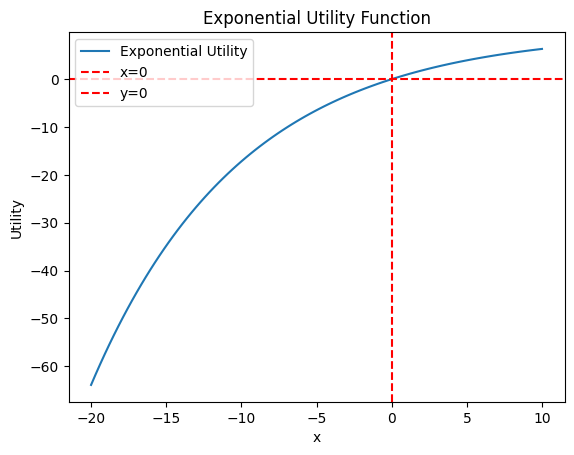

In [24]:

def exponential_utility(x, lambda_val = 0.04):
    return (1 - torch.exp(-lambda_val * x)) / lambda_val

lambda_values = 0.1

x_values = torch.linspace(-20, 10, 100)

utility_values = exponential_utility(x_values, lambda_values)

plt.plot(x_values, utility_values, label='Exponential Utility')
plt.axvline(x=0, color='r', linestyle='--', label='x=0')
plt.axhline(y=0, color='r', linestyle='--', label='y=0')

# plt.axhline(y=-5, color='r', linestyle='--')

# plt.axvline(x=-5, color='g', linestyle='--', label='x=1')
plt.xlabel('x')
plt.ylabel('Utility')
plt.title('Exponential Utility Function')
plt.legend()
plt.show()

#### Training loop


In [ ]:


best_reward = 100

agent = Agent()

# Load previous model
# agent.load_model('model_24.pth')


################################
##       Training Loop        ##
################################

env = MarketEnv( False, Training_data, training_std_data, option_maturity=30,  transaction_cost=0.01)

# env = MarketEnv( False, Testing_data, testing_std_data, option_maturity=30,  transaction_cost=0.01)

for episode in range(30000):
    hist_position = []

    state = env.reset()

    done = False
    total_reward = 0.0
    steps = 0

    while not done:
        steps += 1

        action = agent.choose_act(state)


        if(episode < 20):
            action = np.random.rand()

        next_state, reward, done, info = env.step(action)


        hist_position.append(info["position"])

        reward = torch.tensor(np.array([reward]), dtype=torch.float32)
        action = torch.tensor(np.array([action]), dtype=torch.float32)

        reward = exponential_utility(reward, 0.1)

        total_reward += reward.item()

        if not done:
            agent.store(state, action, next_state, reward, torch.tensor([0]))
        else:
            agent.store(state, action, next_state, reward, torch.tensor([1]))

        agent.learn()
        state = next_state

    print(f"Episode : {episode}    Score : {total_reward:.2f}")
    print("-------------------------------")

    # Evaluation
    if episode % 100 == 0:
        eval_reward = agent.evaluate()

        print(f"Evaluation entropic : {eval_reward:.2f}")
        if eval_reward < best_reward:
            best_reward = eval_reward
            agent.save_model(eval_reward)

    if episode % 100 == 0:
        agent.save_plot(episode)

        # plt.plot(hist_position, label='Position')
        # # plt.plot(env.current_path, label='Price')
        # plt.legend()
        # plt.title(f'Position')
        # plt.show()

    hist_eval_reward.append(eval_reward)
    hist_train_reward.append(total_reward)

# env.close()



In [ ]:
plt.plot(hist_eval_reward, label='Evaluation Reward', alpha=0.5)
# plt.plot(hist_train_reward, label='Training Reward', alpha=0.5)
plt.legend()
plt.title(f'Reward {episode+1}')
plt.show()
